# Instant segmentation with U-Net

## 0. Utils

In [2]:
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from albumentations import (
    Resize,
    Compose,
    Normalize,
    HorizontalFlip,
    RandomBrightnessContrast,
)
import torch
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import numpy as np

## 1. Dataset creation

### 1.1 Dataset class

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_paths = sorted(list(Path(images_dir).glob("*.jpg")))
        self.mask_paths = sorted(list(Path(masks_dir).glob("*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image and mask
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Normalize mask (binary: 0 or 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask

### 1.2 Data augmentation during training

In [4]:
# Training augmentations
train_transform = Compose(
    [
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.2),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Resize(512, 512),
        ToTensorV2(),
    ]
)

# Validation augmentations
val_transform = Compose(
    [
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Resize(512, 512),
        ToTensorV2(),
    ]
)

### 1.3 Data Loader

In [5]:
train_images_dir = "../data/model_training/split/train/images"
train_masks_dir = "../data/model_training/split/train/masks"
val_images_dir = "../data/model_training/split/val/images"
val_masks_dir = "../data/model_training/split/val/masks"
test_images_dir = "../data/model_training/split/test/images"
test_masks_dir = "../data/split/model_training/test/masks"

In [6]:
train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=train_transform)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

### 1.4 Model definition

In [ ]:
%pip install segmentation_models_pytorch

In [ ]:
from segmentation_models_pytorch import Unet

# Define the U-Net model
model = Unet(
    encoder_name="resnet34",  # Encoder backbone
    encoder_weights="imagenet",  # Pretrained on ImageNet
    in_channels=3,  # Input channels (RGB)
    classes=1,  # Output channels (binary segmentation)
)

## 2. Training

Run the following cells if you want train the model, otherwise go to Section 3

### 2.1 Training function

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Loss and optimizer
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)

def save_checkpoint(model, optimizer, epoch, path="unet_model.pth"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch} to {path}")

best_val_loss = float("inf")
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

# Save checkpoint at the end of training
save_checkpoint(model, optimizer, num_epochs, path="unet_model.pth")


### 2.1 Visualize results

In [ ]:
import random

def visualize_test_results(model, dataloader, num_samples=10):
    """
    Visualizes random test results by displaying original images, true masks, and predicted masks.

    Parameters:
        model (torch.nn.Module): Trained model for inference.
        dataloader (DataLoader): DataLoader containing test dataset.
        num_samples (int): Number of random samples to visualize.
    """
    model.eval()

    # Flatten the dataset into a list of indices
    dataset_indices = list(range(len(dataloader.dataset)))

    # Randomly sample indices
    selected_indices = random.sample(
        dataset_indices, min(num_samples, len(dataset_indices))
    )

    with torch.no_grad():
        for idx in selected_indices:
            # Retrieve the image and mask at the selected index
            image, mask = dataloader.dataset[idx]

            # Convert to device and add batch dimension
            image_tensor = image.unsqueeze(0).to(device)
            mask_tensor = mask.unsqueeze(0).to(device)

            # Model prediction
            output = model(image_tensor)
            pred = (torch.sigmoid(output) > 0.5).float()

            # Visualize
            plt.figure(figsize=(12, 6))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(image.permute(1, 2, 0).cpu().numpy())
            plt.title("Original Image")
            plt.axis("off")

            # True mask
            plt.subplot(1, 3, 2)
            plt.imshow(mask.squeeze().cpu().numpy(), cmap="gray")
            plt.title("True Mask")
            plt.axis("off")

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred.squeeze().cpu().numpy(), cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

## 3. Load checkpoint

Load the pre-saved checkpoint

In [8]:
from segmentation_models_pytorch import Unet

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(encoder_name="resnet34", in_channels=3, classes=1).to(device)
model.load_state_dict(torch.load("../checkpoints/unet_model.pth", map_location=device))
# model.load_state_dict(torch.load("../checkpoints/unet_model.pth", map_location=device))
model.eval()

test_transform = Compose(
    [
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Resize(512, 512),
        ToTensorV2(),
    ]
)

/var/folders/w7/n9y0bc4n5zgb8gg118j_j66h0000gn/T/ipykernel_30599/3148963688.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../checkpoi

Run this to visualize the loaded model

## 4. Evaluation

### 4.1 Evaluation matrix

In [10]:
from scipy.spatial.distance import directed_hausdorff


def compute_metrics(model, dataloader):
    model.eval()
    iou_scores = []
    dice_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    hausdorff_distances = []
    mae_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # Compute metrics for each sample
            for pred, mask in zip(preds, masks):
                intersection = (pred * mask).sum().item()
                pred_sum = pred.sum().item()
                mask_sum = mask.sum().item()
                union = pred_sum + mask_sum - intersection

                # IoU
                iou = intersection / (union + 1e-6)
                iou_scores.append(iou)

                # Dice
                dice = 2 * intersection / (pred_sum + mask_sum + 1e-6)
                dice_scores.append(dice)

                # Precision and Recall
                tp = intersection
                fp = pred_sum - intersection
                fn = mask_sum - intersection
                precision = tp / (tp + fp + 1e-6)
                recall = tp / (tp + fn + 1e-6)
                precision_scores.append(precision)
                recall_scores.append(recall)

                # F1 Score
                f1 = 2 * precision * recall / (precision + recall + 1e-6)
                f1_scores.append(f1)

                # Mean Absolute Error (MAE)
                mae = torch.abs(pred - mask).mean().item()
                mae_scores.append(mae)

                # Hausdorff Distance
                pred_indices = torch.nonzero(pred, as_tuple=False).cpu().numpy()
                mask_indices = torch.nonzero(mask, as_tuple=False).cpu().numpy()
                if len(pred_indices) > 0 and len(mask_indices) > 0:
                    hd = max(
                        directed_hausdorff(pred_indices, mask_indices)[0],
                        directed_hausdorff(mask_indices, pred_indices)[0],
                    )
                else:
                    hd = float("inf")  # Handle case with empty prediction or mask
                hausdorff_distances.append(hd)

    # Calculate mean metrics
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_mae = np.mean(mae_scores)
    # mean_hausdorff = np.mean(hausdorff_distances)
    mean_hausdorff = np.mean([d for d in hausdorff_distances if d != float("inf")])

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")
    print(f"Mean MAE: {mean_mae:.4f}")
    print(f"Mean Hausdorff Distance: {mean_hausdorff:.4f}")

    return {
        "iou": mean_iou,
        "dice": mean_dice,
        "precision": mean_precision,
        "recall": mean_recall,
        "f1": mean_f1,
        "mae": mean_mae,
        "hausdorff": mean_hausdorff,
    }


device = "cpu"

In [11]:
# Evaluate on the test set
test_images_dir = "../data/model_training/split/test/images"
test_masks_dir = "../data/model_training/split/test/masks"
test_dataset = SegmentationDataset(
    test_images_dir, test_masks_dir, transform=val_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# Evaluate on the test set
metrics = compute_metrics(model, test_loader)

/var/folders/w7/n9y0bc4n5zgb8gg118j_j66h0000gn/T/ipykernel_30599/2161048088.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0


Mean IoU: 0.8739
Mean Dice: 0.9305
Mean Precision: 0.9217
Mean Recall: 0.9440
Mean F1-Score: 0.9305
Mean MAE: 0.0023
Mean Hausdorff Distance: 12.6954


### 4.2 Best and worse prediction

In [12]:
def display_prediction(title, data):
    """
    Display a single prediction with ground truth and mask.
    Args:
        title: Title of the display (e.g., 'Best Prediction').
        data: Tuple containing image, prediction mask, ground truth mask, index, and IoU.
    Returns:
        None (displays the image with masks).
    """
    if data is None:
        print(f"No {title} found.")
        return

    image, prediction_mask, ground_truth_mask, idx, iou = data
    # Convert image to numpy and scale to [0, 255]
    image_np = image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    #image_np = (image_np * 255).astype(np.uint8)  # Scale to 0-255 for display

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{title} (IoU: {iou:.4f})")

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    # Display ground truth mask
    plt.subplot(1, 3, 2)
    gt_mask_np = ground_truth_mask.squeeze().cpu().numpy()  # Remove channel dimension if present
    plt.imshow(gt_mask_np, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Display predicted mask
    plt.subplot(1, 3, 3)
    pred_mask_np = prediction_mask.squeeze().cpu().numpy()  # Remove channel dimension if present
    plt.imshow(pred_mask_np, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [13]:
def find_best_and_worst_predictions_unet(model, dataloader):
    """
    Evaluate U-Net model on the test dataset and find the best and worst predictions.
    Args:
        model: U-Net model.
        dataloader: DataLoader for the test dataset.
    Returns:
        None (displays the best and worst predictions with their masks).
    """
    model.eval()
    best_iou = -float("inf")
    worst_iou = float("inf")
    best_data = None
    worst_data = None

    with torch.no_grad():
        for idx, (images, ground_truth_mask) in enumerate(dataloader):
            # Move data to the device
            images, ground_truth_mask = images.to(device), ground_truth_mask.to(device)

            # Predict using U-Net
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Binarize predictions

            # Compute IoU for each image in the batch
            for i in range(images.size(0)):
                pred = preds[i]
                gt_mask = ground_truth_mask[i]

                intersection = (pred * gt_mask).sum().item()
                union = (pred + gt_mask).sum().item() - intersection
                iou = intersection / (union + 1e-6)

                # Update best and worst predictions
                if iou > best_iou:
                    best_iou = iou
                    best_data = (images[i], pred, gt_mask, idx, iou)

                if iou < worst_iou:
                    worst_iou = iou
                    worst_data = (images[i], pred, gt_mask, idx, iou)

    # Display results
    display_prediction("Best Prediction", best_data)
    display_prediction("Worst Prediction", worst_data)


/var/folders/w7/n9y0bc4n5zgb8gg118j_j66h0000gn/T/ipykernel_30599/2161048088.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


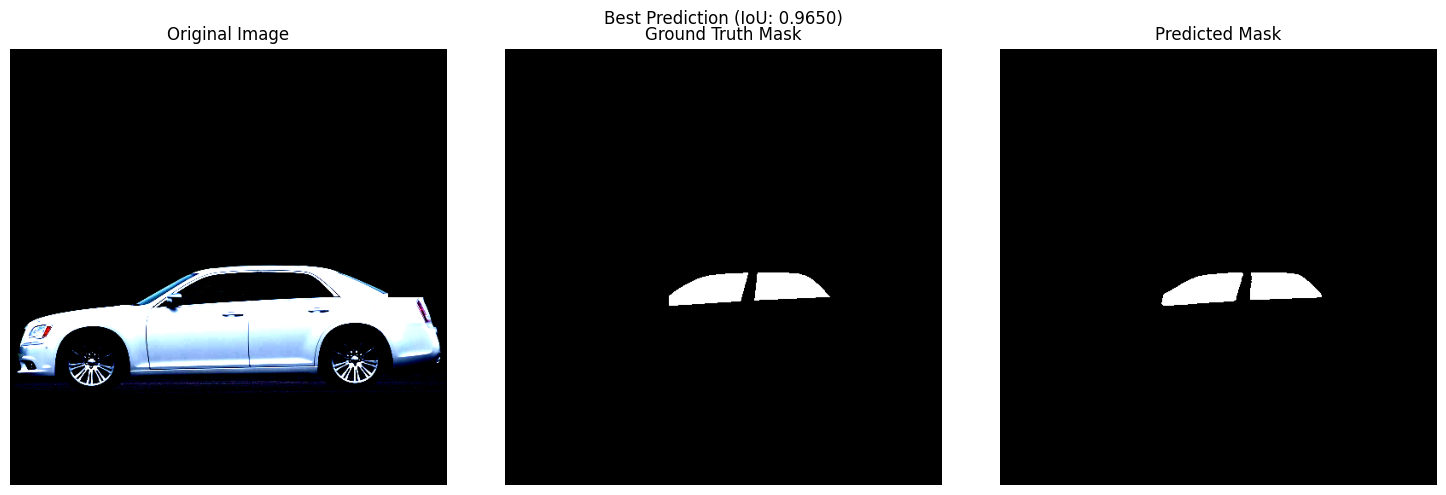

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


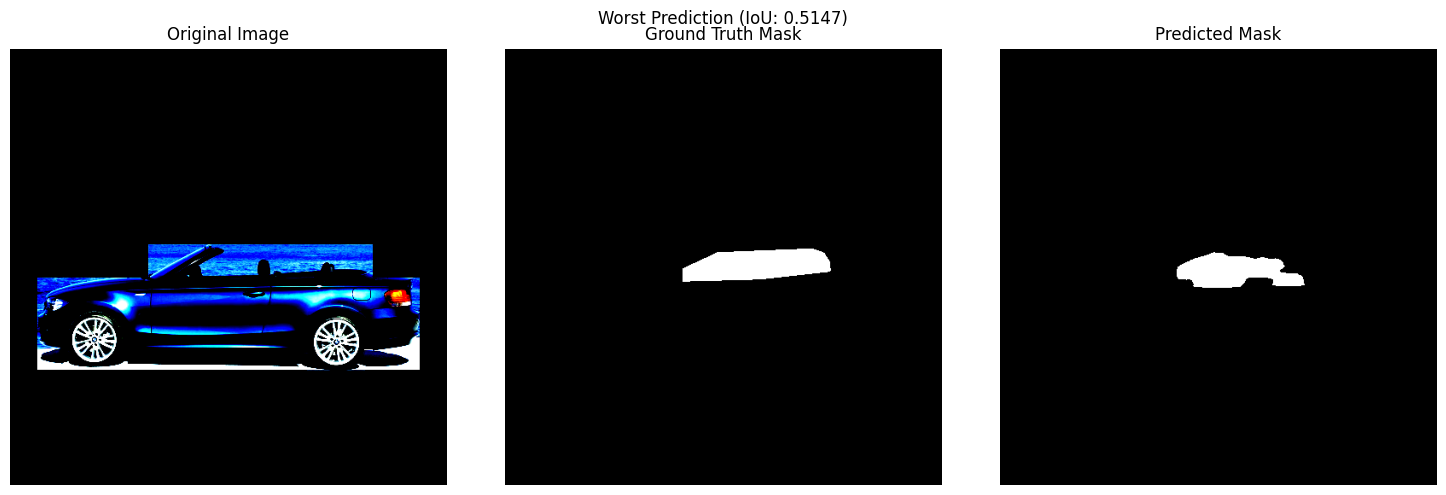

In [14]:
test_images_dir = "../data/model_training/split/test/images"
test_masks_dir = "../data/model_training/split/test/masks"
test_dataset = SegmentationDataset(
    test_images_dir, test_masks_dir, transform=val_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# Evaluate and display best/worst predictions
find_best_and_worst_predictions_unet(model, test_loader)